In [1]:
%pip install stim~=1.14
%pip install numpy~=1.0  # 1.0 instead of 2.0 for pymatching compatibility later
%pip install scipy

  Obtaining dependency information for stim~=1.14 from https://files.pythonhosted.org/packages/a8/82/0a01580071c6d50107298e93faa88250fc30f1538117ec887ec48de7816d/stim-1.15.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import stim
print(stim.__version__)

1.15.0


In [2]:
# Instance of circuit
circuit = stim.Circuit()

# Initialize Bell pair (H-CX)
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Measure of both qubits in Z basis
circuit.append("M", [0, 1])

In [3]:
# display the circuit
circuit

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
''')

In [4]:
circuit.diagram()

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-

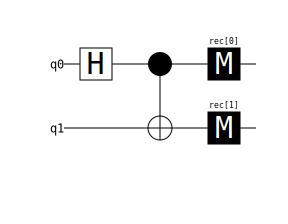

In [5]:
circuit.diagram('timeline-svg')

In [6]:
# 10 measurements from the circuit
sampler = circuit.compile_sampler()
print(sampler.sample(shots = 10))

[[False False]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [False False]
 [False False]]


|00⟩ + |11⟩ state

In [7]:
# Adding detector annotations to circuit
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)]) 
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')


In [8]:
# sample the output with detectors
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots = 5))

[[False]
 [False]
 [False]
 [False]
 [False]]


all false means no detection events

In [9]:
# circuit with noise X_error and tick to track progression of time
circuit = stim.Circuit("""
    H 0
    TICK

    CX 0 1
    X_ERROR(0.2) 0 1
    TICK

    M 0 1
    DETECTOR rec[-1] rec[-2]
""")

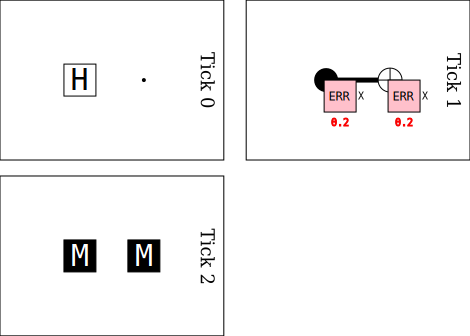

In [10]:
circuit.diagram('timeslice-svg')

In [11]:
# detector outputs after adding noise
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]]


The detection fraction of the circuit is how often detectors fire on average. Given that an X error is being applied to each qubit with 20% probability, and the detector will fire when one of the qubits is hit (but not both), the detection fraction of the detectors in this circuit is 0.8 * 0.2 * 2 = 0.32

Estimation of the detection fraction by just taking a lot of shots, and dividing by the number of shots and the number of detectors

In [12]:
import numpy as np
print(np.sum(sampler.sample(shots=10**6)) / 10**6)

0.319652


very close to 0.32

In [13]:
# error correction circuit
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=25,
    distance=9,
    before_round_data_depolarization=0.4,
    before_measure_flip_probability=0.01)

In [14]:
print(repr(circuit))

stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    TICK
    DEPOLARIZE1(0.4) 0 2 4 6 8 10 12 14 16
    CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    TICK
    CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15
    TICK
    X_ERROR(0.01) 1 3 5 7 9 11 13 15
    MR 1 3 5 7 9 11 13 15
    DETECTOR(1, 0) rec[-8]
    DETECTOR(3, 0) rec[-7]
    DETECTOR(5, 0) rec[-6]
    DETECTOR(7, 0) rec[-5]
    DETECTOR(9, 0) rec[-4]
    DETECTOR(11, 0) rec[-3]
    DETECTOR(13, 0) rec[-2]
    DETECTOR(15, 0) rec[-1]
    REPEAT 24 {
        TICK
        DEPOLARIZE1(0.4) 0 2 4 6 8 10 12 14 16
        CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
        TICK
        CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15
        TICK
        X_ERROR(0.01) 1 3 5 7 9 11 13 15
        MR 1 3 5 7 9 11 13 15
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-8] rec[-16]
        DETECTOR(3, 0) rec[-7] rec[-15]
        DETECTOR(5, 0) rec[-6] rec[-14]
        DETECTOR(7, 0) rec[-5] rec[-13]
        DETECTOR(9, 0) rec[-4] rec

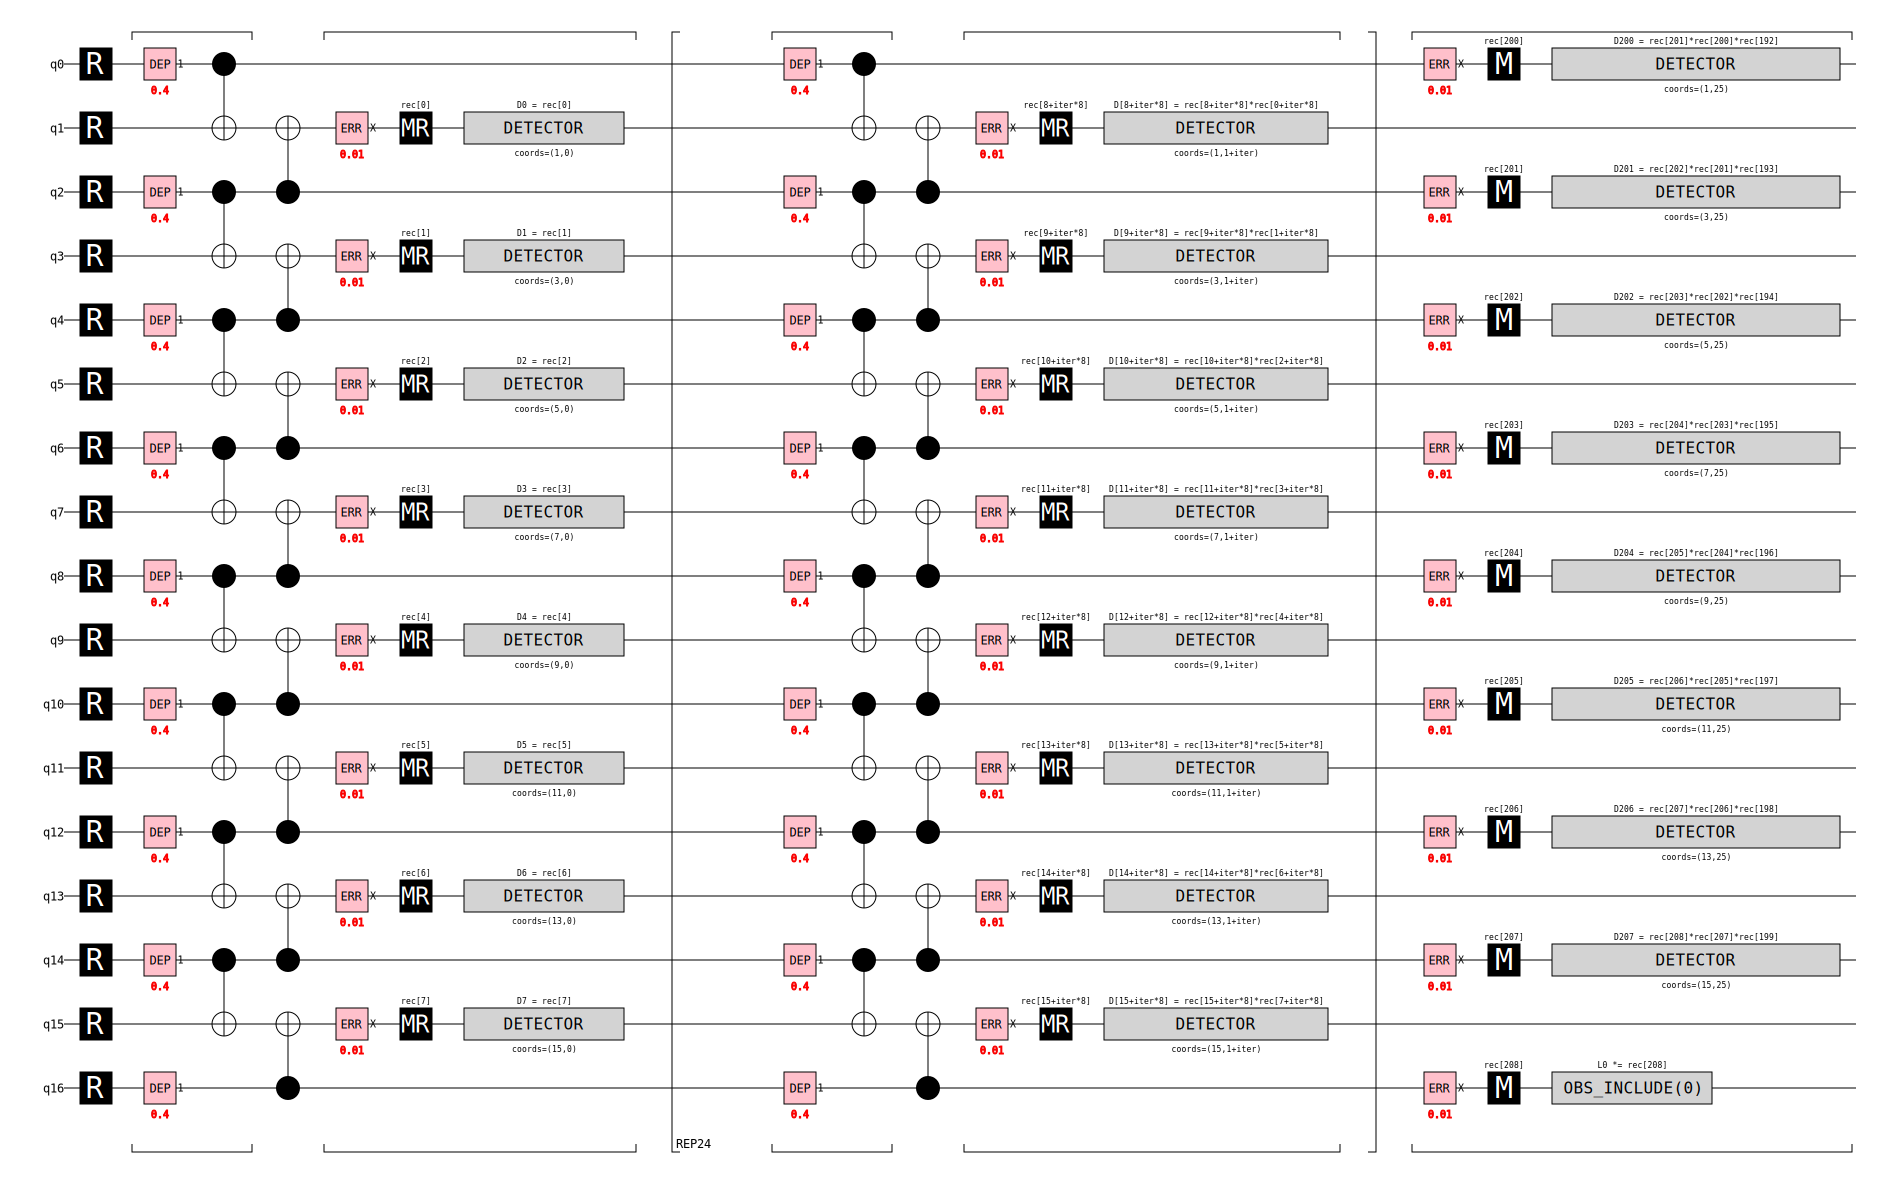

In [15]:
circuit.diagram('timeline-svg')